In [115]:
import pickle
import matplotlib.pyplot as plt
import torch
import io, math
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from s2aenso.utils import data, normalization, metric
from s2aenso.utils.utilities import *

PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/"


colors_swin = ['#1410F2', '#068c08', '#076612', '#c28b0a', '#8a0a6e', '#04c4a7', '#e038b1', '#e9f542']
colors_vit = ['#D42E07', '#1410F2', '#076612', '#c28b0a', '#8a0a6e', '#04c4a7', '#e038b1', '#e9f542']



#####################################################################################################################################################################
###------------------------------------------------ Specify Models -----------------------------------------------------------------------------------------------###
#####################################################################################################################################################################


# Num data & parameter plot
models_vit = [(783685, "1ens_64_128"), (783768, "1ens_128_256"), (783769, "1ens_256_512"), (783771, "1ens_512_1024"), (783793, "10ens_512_1024"), (794316, "10ens_128_256"), (794342, "10ens_256_512"),
              (794353, "10ens_64_128"), (795364, "25ens_64_128"), (795376, "25ens_128_256"), (796095, "25ens_256_512"), (802996, "25ens_512_1024"), (803963, "90ens_128_256"),
              (803970, "90ens_256_512"), (808714, "90ens_512_1024")]

models_swin = [(783684, "1ens_2l_72h"), (783767, "1ens_3l_112h"), (783770, "1ens_2l_256h"), (783772, "1ens_3l_256h"), (794355, "10ens_2l_72h"),
              (794343, "10ens_3l_112h"), (808715, "10ens_2l_256h"), (783794, "10ens_3l_256h"), (795365, "25ens_2l_72h"), (805059, "25ens_3l_112h"),
              (796093, "25ens_2l_256h"), (796157, "25ens_3l_256h"), (808767, "90ens_2l_72h"), (802997, "90ens_3l_112h"), (803971, "90ens_3l_256h")]

models_vit = [(809250, "90ens_64_128")]
models_swin = [(803962, "90ens_2l_256h")]


dataset = "godas"                                   # "cesm2_picontrol" or "oras5" or "godas"
specification = "test_best"                              # "scheduler" or "resolution" or "feature_ablation_notauxy" or "feature_ablation_tauxy" or "feature_ablation_stauxy" or "feature_ablation_lstauxy" or "lower_levels" or "custom_scaling" or "num_data" or "num_params"
metric_acc = "acc_mean_4i"
metric_rmse = "nino_rmse_4_l"                       # 'rmse', 'nino_rmse_3_l', 'nino_rmse_34_l', 'nino_rmse_4_l'
metric_ss = "skillscore_mean_4i"                    # 'ss', 'nino_ss_3_l', 'nino_ss_34_l', 'nino_ss_4_l'


save_dir = f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/final_plots/{dataset}/{specification}/"
create_directory(save_dir)

In [116]:
#####################################################################################################################################################################
###------------------------------------------------ Load Data ----------------------------------------------------------------------------------------------------###
#####################################################################################################################################################################

data_vit = []
data_swinlstm = []

for model_num in models_vit:
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_vit_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:
        cfg_vit = CPU_Unpickler(file).load()
        data_vit.append((cfg_vit, model_num[1]))


for model_num in models_swin:
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_swinlstm_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:   
        cfg_swin = CPU_Unpickler(file).load()
        data_swinlstm.append((cfg_swin, model_num[1]))

In [117]:
print(len(models_vit))

# Loop through ViT data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_vit):
    # Get mean and standard deviation for ViT model
    mean_acc, std_vit = calculate_mean_std(data_vit[i][0]['acc'], metric_acc)
    print(np.mean(mean_acc))


# Loop through ViT data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_swin):
    # Get mean and standard deviation for ViT model
    mean_acc_swin, std_vit_swin = calculate_mean_std(data_swinlstm[i][0]['acc'], metric_acc)
    print(np.mean(mean_acc_swin))

1
0.4372146
0.66718996


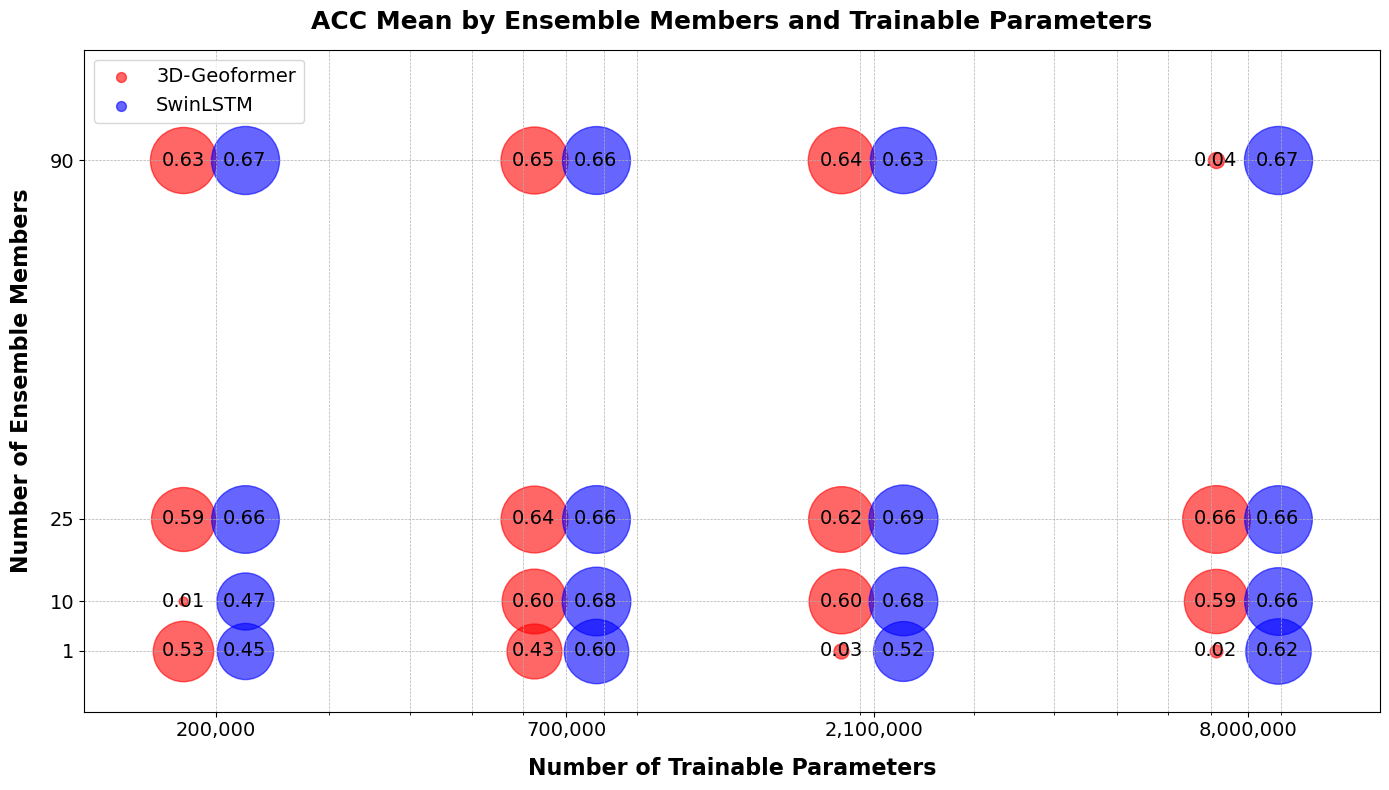

In [4]:
import matplotlib.pyplot as plt

# Define data for models
ensemble_members = [1, 10, 25, 90]
trainable_params = [200_000, 700_000, 2_100_000, 8_000_000]

# Provided accuracy values for 3D-Geoformer (ViT, reshaped into 4x4 grid)
accuracy_geoformer = [
    [0.52582186, 0.43378663, 0.03234212, 0.023519499],
    [0.01123563, 0.6029068, 0.6031868, 0.59388465],
    [0.5887512, 0.64297324, 0.62169826, 0.6606677],
    [0.62936807, 0.64629894, 0.63614521, 0.0372146],
]

# Provided accuracy values for Swin (reshaped into 4x4 grid)
accuracy_swin = [
    [0.45412356, 0.5969404, 0.5158981, 0.6155281],
    [0.46971807, 0.6779535, 0.6767651, 0.6578555],
    [0.65809524, 0.6609084, 0.685721, 0.6576754],
    [0.66729236, 0.66334945, 0.6322265, 0.667188],
]

# Adjusted scaling for small accuracy differences
bubble_scale = 3600  # Adjust bubble scale
min_bubble_size = 20  # Reduced minimum bubble size

# Horizontal shift to avoid overlap
geoformer_shift = -1.1  # Shift bubbles for 3D-Geoformer slightly left
swin_shift = 1.1  # Shift bubbles for Swin slightly right

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot 3D-Geoformer models
for i, num_members in enumerate(ensemble_members):
    for j, params in enumerate(trainable_params):
        if accuracy_geoformer[i][j] is not None:  # Skip missing data points
            bubble_size = max(bubble_scale * abs(accuracy_geoformer[i][j]), min_bubble_size)
            ax.scatter(
                params * (1 + geoformer_shift / 10),  # Apply horizontal shift
                num_members,
                s=bubble_size,
                color='red', alpha=0.6  # Red for 3D-Geoformer
            )
            # Add accuracy label centered in the bubble
            ax.text(
                params * (1 + geoformer_shift / 10), num_members,  # Centered position
                f'{accuracy_geoformer[i][j]:.2f}', fontsize=14, ha='center', va='center', color='black'
            )

# Add only the last scatterplot for 3D-Geoformer to the legend
ax.scatter([], [], s=50, color='red', alpha=0.6, label='3D-Geoformer')

# Plot Swin models
for i, num_members in enumerate(ensemble_members):
    for j, params in enumerate(trainable_params):
        if accuracy_swin[i][j] is not None:  # Skip missing data points
            bubble_size = max(bubble_scale * abs(accuracy_swin[i][j]), min_bubble_size)
            ax.scatter(
                params * (1 + swin_shift / 10),  # Apply horizontal shift
                num_members,
                s=bubble_size,
                color='blue', alpha=0.6  # Blue for Swin
            )
            # Add accuracy label centered in the bubble
            ax.text(
                params * (1 + swin_shift / 10), num_members,  # Centered position
                f'{accuracy_swin[i][j]:.2f}', fontsize=14, ha='center', va='center', color='black'
            )

# Add only the last scatterplot for SwinLSTM to the legend
ax.scatter([], [], s=50, color='blue', alpha=0.6, label='SwinLSTM')

# Customize plot
ax.set_xscale('log')  # Set x-axis to log scale
ax.set_xlabel('Number of Trainable Parameters', fontsize=16, labelpad=12,  fontweight='bold',)  # Add padding to x-axis label
ax.set_ylabel('Number of Ensemble Members', fontsize=16, labelpad=12,  fontweight='bold',)  # Add padding to y-axis label
ax.set_title(
    'ACC Mean by Ensemble Members and Trainable Parameters',
    fontsize=18,
    pad=15,
    fontweight='bold',  # Add padding between title and plot
)

# Show only the specified y-ticks
ax.set_yticks(ensemble_members)
ax.set_yticklabels([f"{ytick}" for ytick in ensemble_members], fontsize=14)

# Adjust x-axis limits for extra padding
padding_factor = 0.6  # Add 20% padding on each side
min_param = min(trainable_params)
max_param = max(trainable_params)
ax.set_xlim(min_param / (1 + padding_factor), max_param * (1 + padding_factor))

# Keep original ylim
ax.set_ylim(-10, 110)

# Adjust x-axis labels
ax.set_xticks(trainable_params)
ax.set_xticklabels([f'{x:,}' for x in trainable_params], fontsize=14)

# Add gridlines
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='upper left', fontsize=14)

# Save and show the plot
plt.tight_layout()
plt.savefig("model_comparison_bubble_plot_geoformer_swin_adjusted.png", dpi=300)
plt.show()


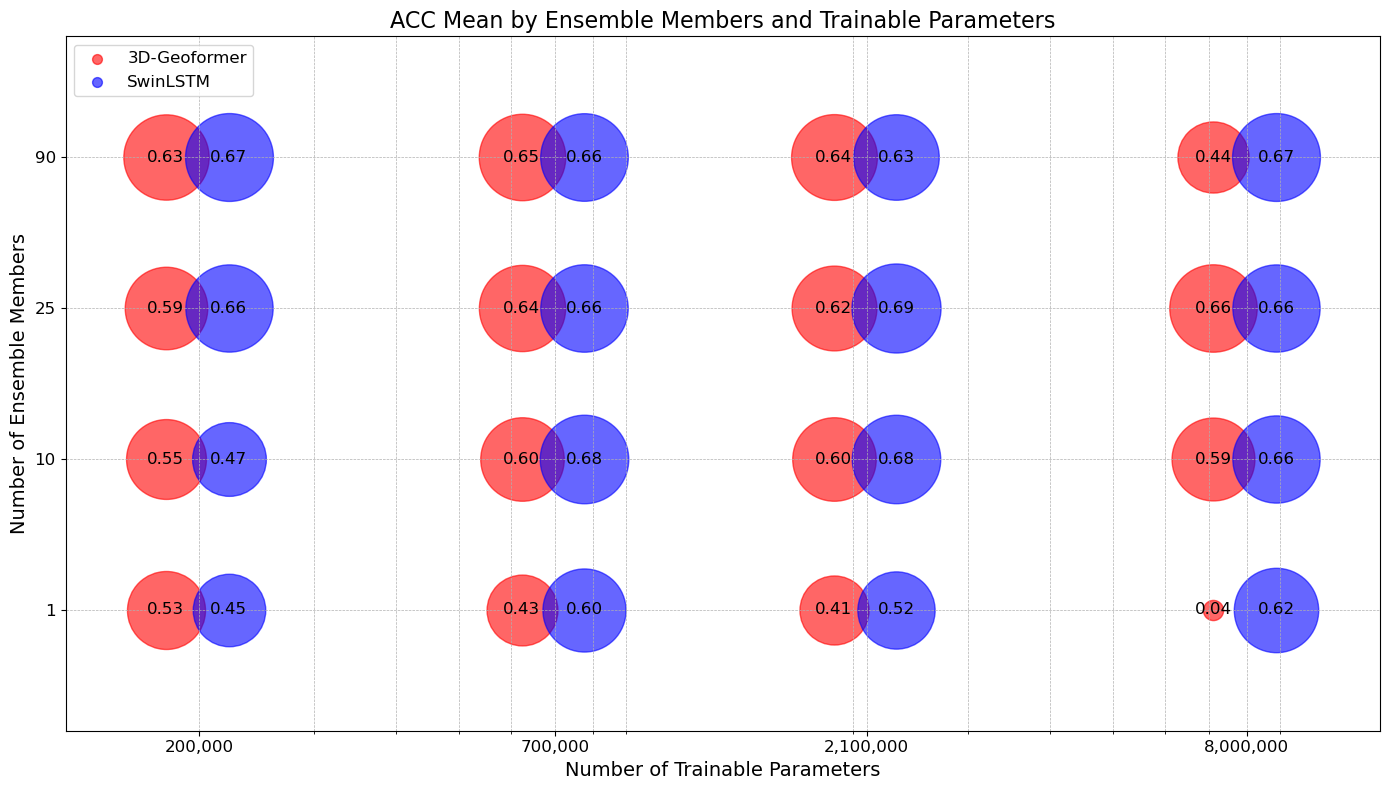

In [119]:
import matplotlib.pyplot as plt

# Define data for models
ensemble_members = [1, 10, 25, 90]
trainable_params = [200_000, 700_000, 2_100_000, 8_000_000]

# Normalized y-values for equal spacing
normalized_ensemble_members = list(range(len(ensemble_members)))

# Provided accuracy values for 3D-Geoformer (ViT, reshaped into 4x4 grid)
accuracy_geoformer = [
    [0.52582186, 0.43378663, 0.41234212, 0.035194997],
    [0.55123563, 0.6029068, 0.6031868, 0.59388465],
    [0.5887512, 0.64297324, 0.62169826, 0.6606677],
    [0.62936807, 0.64629894, 0.63614521, 0.4372146],
]

# Provided accuracy values for Swin (reshaped into 4x4 grid)
accuracy_swin = [
    [0.45412356, 0.5969404, 0.5158981, 0.6155281],
    [0.46971807, 0.6779535, 0.6767651, 0.6578555],
    [0.65809524, 0.6609084, 0.685721, 0.6576754],
    [0.66729236, 0.66334945, 0.6322265, 0.667188],
]

# Adjusted scaling for small accuracy differences
bubble_scale = 6000  # Adjust bubble scale
min_bubble_size = 20  # Reduced minimum bubble size

# Horizontal shift to avoid overlap
geoformer_shift = -1.1  # Shift bubbles for 3D-Geoformer slightly left
swin_shift = 1.1  # Shift bubbles for Swin slightly right

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot 3D-Geoformer models
for i, num_members in enumerate(ensemble_members):
    for j, params in enumerate(trainable_params):
        if accuracy_geoformer[i][j] is not None:  # Skip missing data points
            bubble_size = max(bubble_scale * abs(accuracy_geoformer[i][j]), min_bubble_size)
            ax.scatter(
                params * (1 + geoformer_shift / 10),  # Apply horizontal shift
                normalized_ensemble_members[i],  # Use normalized y-axis
                s=bubble_size,
                color='red', alpha=0.6  # Red for 3D-Geoformer
            )
            # Add accuracy label centered in the bubble
            ax.text(
                params * (1 + geoformer_shift / 10), normalized_ensemble_members[i],  # Centered position
                f'{accuracy_geoformer[i][j]:.2f}', fontsize=12, ha='center', va='center', color='black'
            )

# Add only the last scatterplot for 3D-Geoformer to the legend
ax.scatter([], [], s=50, color='red', alpha=0.6, label='3D-Geoformer')

# Plot Swin models
for i, num_members in enumerate(ensemble_members):
    for j, params in enumerate(trainable_params):
        if accuracy_swin[i][j] is not None:  # Skip missing data points
            bubble_size = max(bubble_scale * abs(accuracy_swin[i][j]), min_bubble_size)
            ax.scatter(
                params * (1 + swin_shift / 10),  # Apply horizontal shift
                normalized_ensemble_members[i],  # Use normalized y-axis
                s=bubble_size,
                color='blue', alpha=0.6  # Blue for Swin
            )
            # Add accuracy label centered in the bubble
            ax.text(
                params * (1 + swin_shift / 10), normalized_ensemble_members[i],  # Centered position
                f'{accuracy_swin[i][j]:.2f}', fontsize=12, ha='center', va='center', color='black'
            )

# Add only the last scatterplot for SwinLSTM to the legend
ax.scatter([], [], s=50, color='blue', alpha=0.6, label='SwinLSTM')

# Customize plot
ax.set_xscale('log')  # Set x-axis to log scale
ax.set_xlabel('Number of Trainable Parameters', fontsize=14)
ax.set_ylabel('Number of Ensemble Members', fontsize=14)
ax.set_title('ACC Mean by Ensemble Members and Trainable Parameters', fontsize=16)

# Map normalized y-ticks back to original labels
ax.set_yticks(normalized_ensemble_members)
ax.set_yticklabels([f"{ytick}" for ytick in ensemble_members], fontsize=12)

# Adjust ylim to add padding
padding = 0.8  # Increase spacing above and below
ax.set_ylim(-padding, len(ensemble_members) - 1 + padding)

# Adjust x-axis labels
ax.set_xticks(trainable_params)
ax.set_xticklabels([f'{x:,}' for x in trainable_params], fontsize=12)

# Adjust x-axis limits for extra padding
padding_factor = 0.6  # Add 20% padding on each side
min_param = min(trainable_params)
max_param = max(trainable_params)
ax.set_xlim(min_param / (1 + padding_factor), max_param * (1 + padding_factor))

# Add gridlines
ax.grid(which='both', linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='upper left', fontsize=12)

# Save and show the plot
plt.tight_layout()
plt.savefig("model_comparison_bubble_plot_geoformer_swin_adjusted2.png", dpi=300)
plt.show()
